In [1]:
import numpy as np
import matplotlib.pyplot as plt
from reinforced_concrete.sections import create_concrete_material, create_steel_material

plt.style.use(["science"])
#plt.style.use(["science", "notebook"]) # faster but witout LaTeX render

ConcreteMaterial(fck=30, rck=37, fcm=38, fcd=17.0, Ecm=32836.57, fctm=2.896, fctk=2.028, fctd=1.3517, ec2=0.002, ecu2=0.0035, ec3=0.00175, ecu3=0.0035)
SteelMaterial(fyk=450, Es=210000)
(18.594893478925393, 331.7592796051659)


In [2]:
c  = create_concrete_material("EC2","C30/37") #TODO
s  = create_steel_material("NTC18","B450C")
s1 = create_steel_material("NTC18","B450C")
print(c)
print(s)

ConcreteMaterial(fck=30, rck=37, fcm=38, fcd=17.0, Ecm=32836.57, fctm=2.896, fctk=2.028, fctd=1.3517, ec2=0.002, ecu2=0.0035, ec3=0.00175, ecu3=0.0035)
SteelMaterial(fyk=450, Es=210000)


In [3]:
b = 400
h = 450
As = 1407
As1 = 1206
d = 410
d1 = 40
d2 = 40

fck = 25
fyk = 450
fyk1 = 450
Ec = 31475.806
Es = 200000

ese = 1.9565/1000
ese1 = 1.9565/1000
esu = 10/1000 # campo 1 e 2
ecu = 3.5/1000
ec = 3.5/1000
ec2 = 2/1000



In [4]:
xi23 = ecu/(ecu + esu)
xi23

0.25925925925925924

In [5]:
xi34 = ecu/(ecu + ese1)
xi34

0.6414368184733804

In [6]:
# NO
xi2a2b = (d2/d * esu - ese1) / (esu -ese1) 
xi2a2b

-0.12194818721979721

In [7]:
def storeToDict(dic,strainRange,N,M,nu,mu):
    dic[strainRange]["N"] = N
    dic[strainRange]["M"] = M
    dic[strainRange]["nu"] = nu
    dic[strainRange]["mu"] = mu
    

In [8]:
# Strain Range 2
def psi_2(xi):
    if xi < 1/6:
        return xi/(1-xi) * esu/(3 * ec2**2) * (3 * ec2 - xi/(1-xi) * esu)
    else:
        return 1 - ( ec2*(1-xi) ) / ( 3*esu*xi )

def lamb_2(xi):
# only for n = 2 C<C50/60
    if xi == 0: #TODO perché si faceva ?
        return 0
    elif xi <= 1/6:
        return (4*ec2 - esu*xi/(1-xi)) / (4*(3*ec2 - esu*xi/(1-xi))) 
    else:
        return ( (6*esu**2 + 4*esu*ec2 +  ec2**2)*xi**2 - 2*ec2**2 * xi + ec2**2 - 4*esu*ec2*xi ) / ( 4*esu*xi*((3*esu+ec2)*xi - ec2 ))        

In [9]:
def strainDistribution(As,As1) -> dict[dict]:
    """
    Return a dictionary of dictionaries for each stain range (1-6) with numpy arrays of M, N, mu, nu values
    
    Example: 
    As = 1407
    As1 = 1206
    MN_up = strainDistribution(As,As1)
    MN_up["2"]["M"] is an array with M values for strain range 2
    """
    dic = {}
    fcd = fck * 0.85 / 1.5
    fyd = fyk/1.15 
    
    # ---------------------------------------------------------------------
    # ------------------------------ CAMPO 2 ------------------------------
    # ---------------------------------------------------------------------
    
    strainRange = "2"
    dic[strainRange]={}

    xi = np.linspace(0,xi23,130)
    x = xi * d
    es1 = - (esu * (x - d2)) /(d - x) #TODO tanto vale mettere la formula con xi (ovunque)

    fyd1 = []
    for i in range(len(es1)):
        if abs(es1[i]) > ese1 and es1[i] > 0:
            fyd1.append(fyk1/1.15)
        elif abs(es1[i]) > ese1 and es1[i] < 0:
            fyd1.append(-fyk1/1.15)
        else:
            fyd1.append(Es * es1[i])
    fyd1 = np.array(fyd1)        

    psi = np.array([psi_2(xi_i) for xi_i in xi])
    lamb = np.array([lamb_2(xi_i) for xi_i in xi])

    N = b * psi * x * fcd  - fyd1*As1 - fyd * As 
    M = b * psi * x * fcd * (h/2 - lamb*x)  - fyd1*As1* (h/2 - d2) + fyd * As* (h/2 - d1)
    nu = N/(b*d*fcd)
    mu = M/(b*d**2*fcd)
    
    storeToDict(dic,strainRange,N,M,nu,mu)
    
    # ---------------------------------------------------------------------
    # ------------------------------ CAMPO 3 ------------------------------
    # ---------------------------------------------------------------------
    
    strainRange = "3"
    dic[strainRange]={}
    
    fyd = fyk/1.15

    xi = np.linspace(xi23,xi34,100)
    x = xi * d

    es1 = - ecu * (x - d2) / x

    fyd1 = -fyk1/1.15  

    psi = 17/21 # 0.8095238095238095
    lamb = 99/238 # 0.4159663865546219

    # solo campo 3B. Da capire il 3A perché non lo considera!
    
    N = b * psi * x * fcd  - fyd1*As1 - fyd * As  
    M = b * psi * x * fcd * (h/2 - lamb*x)  - fyd1*As1* (h/2 - d2) + fyd * As* (h/2 - d1)
    nu = N/(b*d*fcd)
    mu = M/(b*d**2*fcd)
    
    storeToDict(dic,strainRange,N,M,nu,mu)
    
    # ---------------------------------------------------------------------
    # ------------------------------ CAMPO 4 ------------------------------
    # ---------------------------------------------------------------------
    
    strainRange = "4"
    dic[strainRange]={}

    xi = np.linspace(xi34,1,100)
    x = xi * d

    es1 = - ecu * (x - d2) / x
    es = ecu * (d-x) / x

    fyd1 = -fyk1/1.15  
    fyd = Es*es

    psi = 17/21 # 0.8095238095238095
    lamb = 99/238 # 0.4159663865546219
    
    N = b * psi * x * fcd  - fyd1*As1 - fyd * As  
    M = b * psi * x * fcd * (h/2 - lamb*x)  - fyd1*As1* (h/2 - d2) + fyd * As* (h/2 - d1)
    nu = N/(b*d*fcd)
    mu = M/(b*d**2*fcd)
    
    storeToDict(dic,strainRange,N,M,nu,mu)
    
    # ---------------------------------------------------------------------
    # ------------------------------ CAMPO 5 ------------------------------
    # ---------------------------------------------------------------------
    
    strainRange = "5"
    dic[strainRange]={}

    xi = np.linspace(1,1+d1/d,20)
    x = xi * d

    es1 = - ecu * (x - d2) / x
    es = - ecu * (d-x) / x

    fyd1 = -fyk1/1.15  
    fyd = - Es*es
    psi = 17/21 # 0.8095238095238095
    lamb = 99/238 # 0.4159663865546219
    
    N = b * psi * x * fcd  - fyd1*As1 - fyd * As  
    M = b * psi * x * fcd * (h/2 - lamb*x)  - fyd1*As1* (h/2 - d2) + fyd * As* (h/2 - d1)
    nu = N/(b*d*fcd)
    mu = M/(b*d**2*fcd)
    
    storeToDict(dic,strainRange,N,M,nu,mu)
    # ------------------------------------
    
    return dic

In [10]:
# Above and below x axis: invert steel areas and change M sign in plotting function 
MN_up = strainDistribution(As,As1)
MN_down = strainDistribution(As1,As) 

In [11]:
def create_multiple_strainDistribution(As: list, As1: list) -> list[tuple[dict]]:
    """example [(MN_up_1, MN_down_1), (MN_up_2, MN_down_2), ...]"""
    multiple_strain_distributions = []
    for i in range(len(As1)):
        # tup: (mn_up, mn_down)
        tup = strainDistribution(As[i], As1[i]), strainDistribution(As1[i], As[i])
        multiple_strain_distributions.append(tup)
    return multiple_strain_distributions

def a(bars: int , diameter: int):
    return bars * 3.14 * diameter**2 / 4


As_list = [a(4,12),a(4,14), a(4,16)]
As1_list = [a(2,12),a(2,14), a(2,16)]

mult = create_multiple_strainDistribution(As_list,As1_list)

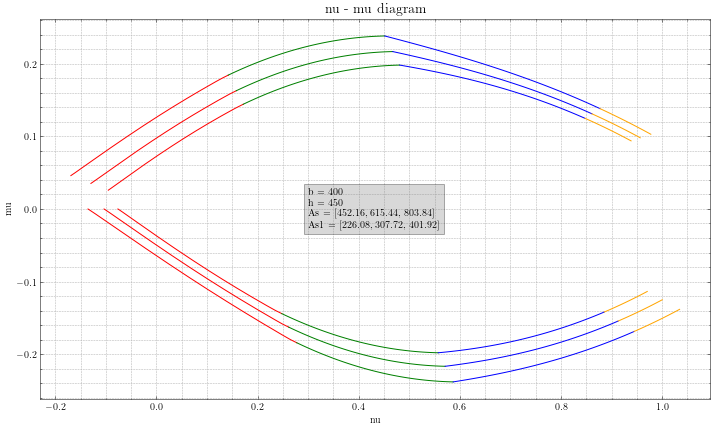

In [18]:
COLORS = ["red","green","blue","orange"]
def interaction_diagram_single(dic_up,dic_down):
    fig, ax = plt.subplots(1,1, figsize = (7, 5))
    ax.set_xlabel('nu')
    ax.set_ylabel('mu')

    for i in range(2,6): #(1,7) when finisched
        k = i - 2 # i -1
        i = str(i)
        ax.plot(dic_up[i]["nu"],dic_up[i]["mu"],dic_down[i]["nu"],-dic_down[i]["mu"],color=COLORS[k],label=i)
        ax.legend()

def interaction_diagram_multiple(
        multiple_strainDistribution: create_multiple_strainDistribution, 
        NM=True,
        NM_values: list = None
    ):
    x = "N" if NM else "nu"
    y = "M" if NM else "mu"

    fig, ax = plt.subplots(1,1, figsize = (12, 7))
    ax.set_xlabel(x) # "r"$\bf" + x + r"}$""
    ax.set_ylabel(y)
    ax.grid("True",which="both",linestyle='dashed')
    ax.set_title(f"{x} - {y} diagram", fontsize=14)
    for area in range(len(multiple_strainDistribution)):
        for i in range(2,6): #(1,7) when finisched #TODO 
            k = i - 2 # i -1 #togliere completamente k #TODO
            i = str(i)
            dic_up, dic_down = multiple_strainDistribution[area]
            ax.plot(dic_up[i][x],dic_up[i][y],dic_down[i][x],-dic_down[i][y],color=COLORS[k])
        #ax.plot([],[], label=f"Area: {area}")    
    ax.text(
        x=0.4, 
        y=0.5, 
        s=f"b = {b}\nh = {h}\nAs   = {As_list} \nAs1 = {As1_list} ", 
        horizontalalignment='left',
        verticalalignment='center', 
        transform=ax.transAxes, #used to make x,y coords in global coordinates
        bbox=dict(facecolor='grey', alpha=0.3)
    )
    if NM_values:
        x_points = NM_values[0]
        y_points = NM_values[1]
        ax.plot(x_points, y_points,"rs")

    #plt.savefig(f"{x}_{y}_diagram.pdf")
#interaction_diagram_single(MN_up,MN_down)
interaction_diagram_multiple(mult, NM = False) # , NM_values=[[1,3],[2,6]]



In [13]:
from dataclasses import dataclass

@dataclass
class Bars:
    n_bars: int
    diameter: int

    def a(self):
        "Area"
        return self.n_bars * 3.14 * self.diameter**2 / 4

    def __str__(self):
        "Return a string like:'2Ø4' "
        return f"{self.n_bars}Ø{self.diameter}"
   
sup = Bars(2,4)
print(sup)



2Ø4


In [14]:
stop

NameError: name 'stop' is not defined

In [ ]:
fcd = fck * 0.85 / 1.5

t = (ecu-ec2)*(d+d1)/ecu # C<C50/60: 3/7 * h

xi = np.linspace(1+d1/d,50,1000)
x = xi * d

es1 = - ec2 * (x - d2) / (x-t)
es = - ec2 * (x-d) / (x-t)

fyd1 = -fyk1/1.15  

#x6a6b = (ec2 * d + ese * t)/(ec2 + ese)

fyd = []
for i in range(len(x)):
    if abs(es[i]) < ese:
        fyd.append(Es * es[i])
    else:
        fyd.append(- fyk/1.15)
fyd = np.array(fyd)

psi = []
# n = 2 C<C50/60
for i in range(len(xi)):
    psi.append( (xi[i]**2 - 6/7*xi[i] + 125/1029) / (xi[i] - 3/7)**2 )
psi = np.array(psi)  

lamb = [] #lambda
# n = 2 C<C50/60
for i in range(len(xi)):
    lamb.append( 3/14 * (2401*xi[i]**2 - 2058*xi[i] + 185 )/( 1029*xi[i]**2 - 882*xi[i] +125 ) )        
lamb = np.array(lamb) 

N = b * psi * h * fcd  - fyd1*As1 + fyd * As  
M = b * psi * h * fcd * (h/2 - lamb*h)  - fyd1*As1* (h/2 - d2) + fyd * As* (h/2 - d1)
nu = N/(b*d*fcd)
mu = M/(b*d**2*fcd)

In [ ]:
fyd1 = []
for i in range(len(es1)):
    if abs(es1[i]) > ese1 and es1[i] > 0:
        fyd1.append(fyk1/1.15)
    elif abs(es1[i]) > ese1 and es1[i] < 0:
        fyd1.append(-fyk1/1.15)
    else:
        fyd1.append(Es * es1[i])
fyd1 = np.array(fyd1) 

In [ ]:
(xi[0]**2 - 6/7*xi[0] + 125/1029) / ((xi[0] - 3/7)**2)

0.8610284391534392

In [ ]:
1/(3*ecu) * ( 3*ecu - ec2*( (1-t/h)/(xi[0]-t/h) )**2 )

0.8610284391534392

In [ ]:
xi[0]

1.0975609756097562

In [ ]:
3/14 * (2401*xi[0]**2 - 2058*xi[0] + 185 )/( 1029*xi[0]**2 - 882*xi[0] +125)

0.442356491324326